# Example modeling process

### Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model specific imports
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import (get_training_observations, 
                     get_training_labels, 
                     get_protein_proportions,
                     drop_empty_columns)

### Load training data and labels

In [2]:
x_train_raw_counts = get_training_observations()
x_train = get_protein_proportions(x_train_raw_counts)
print(f"There are {x_train.shape[1]} features")
y_train = get_training_labels()

Getting all training observations from 'metagenome_classification.db'...
There are 16306 features
Getting all training labels from 'metagenome_classification.db'...


In [3]:
x_train.head(10)

index,PF00001.19,PF00002.22,PF00003.20,PF00004.27,PF00005.25,PF00006.23,PF00007.20,PF00008.25,PF00009.25,PF00010.24,...,PF17216.1,PF17217.1,PF17218.1,PF17219.1,PF17220.1,PF17221.1,PF17222.1,PF17223.1,PF17224.1,PF17225.1
0,0.000004,6.092434e-07,0.000000,0.001285,0.021986,0.000809,0.0,0.000010,0.001546,6.092434e-07,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000010,0.000000e+00,0.000003,0.001523,0.015320,0.001126,0.0,0.000024,0.002005,3.392429e-06,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.000000e+00,0.000000,0.001595,0.011640,0.001008,0.0,0.000000,0.001650,0.000000e+00,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.000000e+00,0.000010,0.002188,0.018117,0.001597,0.0,0.000000,0.002543,0.000000e+00,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000002,0.000000e+00,0.000000,0.001786,0.014518,0.000924,0.0,0.000000,0.001915,3.916983e-06,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5,0.000012,1.197289e-05,0.000000,0.002706,0.008824,0.001257,0.0,0.000000,0.002155,0.000000e+00,...,0.000012,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
6,0.000000,0.000000e+00,0.000000,0.002233,0.013982,0.001488,0.0,0.000005,0.002459,5.383928e-06,...,0.000005,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
7,0.000000,0.000000e+00,0.000000,0.001661,0.018014,0.000828,0.0,0.000000,0.001876,0.000000e+00,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
8,0.005429,9.319447e-05,0.000047,0.001631,0.012302,0.000815,0.0,0.000396,0.001375,3.494793e-04,...,0.000000,0.000047,0.0,0.0,0.0,0.000023,0.0,0.0,0.0,0.0
9,0.000008,0.000000e+00,0.000000,0.002739,0.016584,0.001230,0.0,0.000000,0.002286,0.000000e+00,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [4]:
y_train.head()

index,EMPO_1,EMPO_2,EMPO_3
0,Host-associated,Plant,Plant rhizosphere
1,Free-living,Non-saline,Soil (non-saline)
2,Free-living,Saline,Water (saline)
3,Free-living,Non-saline,Water (non-saline)
4,Free-living,Non-saline,Soil (non-saline)


### Data manipulation
Validation splits, dimensionality reduction, etc

In [5]:
# convert string labels to numeric
labels3 = [
    'Aerosol (non-saline)',
    'Animal corpus',
    'Animal proximal gut',
    'Hypersaline (saline)',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Sediment (saline)',
    'Soil (non-saline)',
    'Subsurface (non-saline)',
    'Surface (non-saline)',
    'Surface (saline)',
    'Water (non-saline)',
    'Water (saline)'
]
labels3_map = {}
for i in range(0,len(labels3)):
    label = labels3[i]
    labels3_map[label] = i

y_train['EMPO_3_int'] = y_train['EMPO_3'].map(labels3_map)

In [6]:
# Split into train/validation if not CV
X_tr, X_val, Y_tr, Y_val = train_test_split(x_train, y_train, test_size=0.2) #, random_state=1)

# Dimensionality reduction?
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
svd.fit(X_tr)

new_x_train = svd.transform(X_tr)
new_x_val = svd.transform(X_val)


In [7]:
# convert string labels to numeric
#Y_tr['EMPO_3_int'] = Y_tr['EMPO_3'].map(labels3_map)
#Y_tr.head()
#Y_val['EMPO_3_int'] = Y_val['EMPO_3'].map(labels3_map)

### Model training

Training...
Epoch 1/20


2022-07-30 00:56:37.597476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


15/15 [==============================] - 3s 164ms/step - loss: 2.0698 - accuracy: 0.4260 - val_loss: 1.7780 - val_accuracy: 0.3700
Epoch 2/20
15/15 [==============================] - 2s 144ms/step - loss: 1.5830 - accuracy: 0.5095 - val_loss: 1.5538 - val_accuracy: 0.4500
Epoch 3/20
15/15 [==============================] - 2s 139ms/step - loss: 1.3391 - accuracy: 0.5806 - val_loss: 1.5808 - val_accuracy: 0.4700
Epoch 4/20
15/15 [==============================] - 2s 144ms/step - loss: 1.2050 - accuracy: 0.6707 - val_loss: 1.3242 - val_accuracy: 0.5600
Epoch 5/20
15/15 [==============================] - 2s 167ms/step - loss: 1.0753 - accuracy: 0.7130 - val_loss: 1.2851 - val_accuracy: 0.6000
Epoch 6/20
15/15 [==============================] - 2s 167ms/step - loss: 1.0420 - accuracy: 0.7253 - val_loss: 1.1675 - val_accuracy: 0.7200
Epoch 7/20
15/15 [==============================] - 2s 147ms/step - loss: 0.9642 - accuracy: 0.7597 - val_loss: 1.1711 - val_accuracy: 0.6400
Epoch 8/20
15/15 

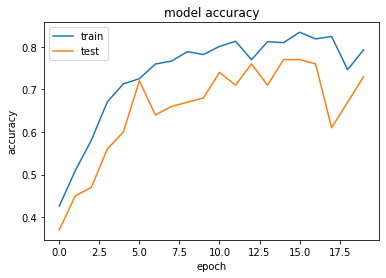

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 974)               15883018  
                                                                 
 dropout (Dropout)           (None, 974)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                14625     
                                                                 
Total params: 15,897,643
Trainable params: 15,897,643
Non-trainable params: 0
_________________________________________________________________


In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

def build_model(n_classes,
  hidden_layer_sizes=[],
  activation='relu',
  final_layer_activation='softmax',
  dropout=0.0,
  kernel_regularizer=1e-5,
  bias_regularizer=1e-5,
  activity_regularizer=1e-5,
  optimizer='Adam',
  learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)
  model = keras.Sequential()
  model.add(keras.layers.Flatten())

  for hidden_layer_size in hidden_layer_sizes:
        if hidden_layer_size > n_classes:
            model.add(keras.layers.Dense(
                hidden_layer_size,
                activation=activation,
                kernel_regularizer=keras.regularizers.L2(kernel_regularizer),
                bias_regularizer=keras.regularizers.L2(bias_regularizer),
                activity_regularizer=keras.regularizers.L2(activity_regularizer)
            ))
            if dropout > 0:
                model.add(keras.layers.Dropout(dropout))
  model.add(keras.layers.Dense(
        n_classes,
        activation=final_layer_activation,
        kernel_regularizer=keras.regularizers.L2(kernel_regularizer),
        bias_regularizer=keras.regularizers.L2(bias_regularizer),
        activity_regularizer=keras.regularizers.L2(activity_regularizer)
  ))
  opt = None
  if optimizer == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  else:
    raise f"Unsupported optimizer, {optimizer}"
  model.compile(loss='sparse_categorical_crossentropy', 
    optimizer=opt, metrics=['accuracy'])    
  return model

def train_model(X_train, Y_train, num_classes,
  hidden_layer_sizes=[],
  kernel_regularizer=0,
  bias_regularizer=0,
  activity_regularizer=0,
  activation='tanh',
  final_layer_activation='softmax',
  dropout=0.2,
  optimizer='Adam',
  learning_rate=0.01,
  batch_size=64,
  num_epochs=5):

  # Build the model.
  model = build_model(
        num_classes,
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        final_layer_activation=final_layer_activation,
        dropout=dropout,
        kernel_regularizer=1e-5,
        bias_regularizer=1e-5,
        activity_regularizer=1e-5,
        optimizer=optimizer,
        learning_rate=learning_rate)

  # Train the model.
  print('Training...')
  history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  model.summary()
  return model

# model with 1 hidden layers
nn1 = train_model(X_tr, Y_tr['EMPO_3_int'], 15,
    hidden_layer_sizes=[974],
    kernel_regularizer=1.9e-08,
    bias_regularizer=4.8e-05,
    activity_regularizer=1.1e-06,
    dropout=0.058,
    optimizer='Adam',
    learning_rate=0.009,
    batch_size=64,
    num_epochs=20)



Training...
Epoch 1/20
15/15 [==============================] - 2s 90ms/step - loss: 2.0787 - accuracy: 0.3204 - val_loss: 1.6944 - val_accuracy: 0.3700
Epoch 2/20
15/15 [==============================] - 1s 61ms/step - loss: 1.4638 - accuracy: 0.4750 - val_loss: 1.4924 - val_accuracy: 0.4300
Epoch 3/20
15/15 [==============================] - 1s 53ms/step - loss: 1.1969 - accuracy: 0.6107 - val_loss: 1.4098 - val_accuracy: 0.5300
Epoch 4/20
15/15 [==============================] - 1s 67ms/step - loss: 1.0292 - accuracy: 0.6752 - val_loss: 1.1997 - val_accuracy: 0.5700
Epoch 5/20
15/15 [==============================] - 1s 65ms/step - loss: 0.8517 - accuracy: 0.7597 - val_loss: 1.0552 - val_accuracy: 0.6300
Epoch 6/20
15/15 [==============================] - 1s 42ms/step - loss: 0.7969 - accuracy: 0.7519 - val_loss: 1.0057 - val_accuracy: 0.6900
Epoch 7/20
15/15 [==============================] - 1s 42ms/step - loss: 0.7623 - accuracy: 0.7809 - val_loss: 0.9278 - val_accuracy: 0.7700
E

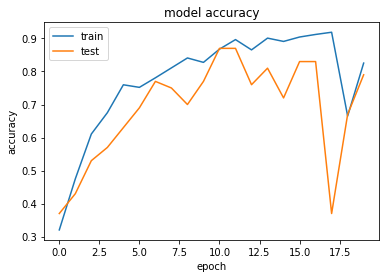

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 231)               3766917   
                                                                 
 dropout (Dropout)           (None, 231)               0         
                                                                 
 dense_1 (Dense)             (None, 303)               70296     
                                                                 
 dropout_1 (Dropout)         (None, 303)               0         
                                                                 
 dense_2 (Dense)             (None, 15)                4560      
                                                                 
Total params: 3,841,773
Trainable params: 3,841,773
Non-

In [9]:
# model with 2 hidden layers
nn2 = train_model(X_tr, Y_tr['EMPO_3_int'], 15,
    hidden_layer_sizes=[231, 303],
    kernel_regularizer=4.5e-06,
    bias_regularizer=2.3e-05,
    activity_regularizer=5.4e-05,
    dropout=0.067,
    optimizer='Adam',
    learning_rate=0.0073,
    batch_size=64,
    num_epochs=20)

Training...
Epoch 1/20
15/15 [==============================] - 5s 251ms/step - loss: 2.1973 - accuracy: 0.2581 - val_loss: 1.8435 - val_accuracy: 0.3900
Epoch 2/20
15/15 [==============================] - 3s 178ms/step - loss: 1.5800 - accuracy: 0.4627 - val_loss: 1.4784 - val_accuracy: 0.4300
Epoch 3/20
15/15 [==============================] - 3s 184ms/step - loss: 1.2877 - accuracy: 0.5684 - val_loss: 1.4263 - val_accuracy: 0.5000
Epoch 4/20
15/15 [==============================] - 3s 182ms/step - loss: 1.0747 - accuracy: 0.6285 - val_loss: 1.2250 - val_accuracy: 0.6100
Epoch 5/20
15/15 [==============================] - 2s 166ms/step - loss: 0.9031 - accuracy: 0.7219 - val_loss: 1.1782 - val_accuracy: 0.6500
Epoch 6/20
15/15 [==============================] - 4s 241ms/step - loss: 0.8295 - accuracy: 0.7275 - val_loss: 0.9775 - val_accuracy: 0.7100
Epoch 7/20
15/15 [==============================] - 4s 255ms/step - loss: 0.7330 - accuracy: 0.7753 - val_loss: 0.8935 - val_accuracy: 0

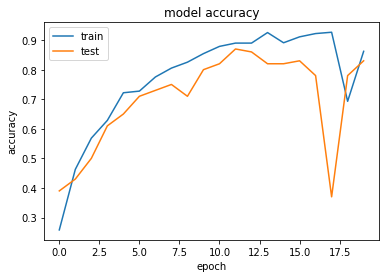

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 1003)              16355921  
                                                                 
 dropout (Dropout)           (None, 1003)              0         
                                                                 
 dense_1 (Dense)             (None, 935)               938740    
                                                                 
 dropout_1 (Dropout)         (None, 935)               0         
                                                                 
 dense_2 (Dense)             (None, 298)               278928    
                                                                 
 dropout_2 (Dropout)         (None, 298)               0

In [10]:
# model with 3 hidden layers
nn3 = train_model(X_tr, Y_tr['EMPO_3_int'], 15,
    hidden_layer_sizes=[1003, 935, 298],
    kernel_regularizer=5.0e-06,
    bias_regularizer=2.0e-05,
    activity_regularizer=10.0e-05,
    dropout=0.025,
    optimizer='Adam',
    learning_rate=0.0015,
    batch_size=64,
    num_epochs=20)

### Model evaluation

In [13]:
# Scoring model
nn1_accuracy = nn1.evaluate(x=X_val, y=Y_val['EMPO_3_int'], verbose=0, return_dict=True)['accuracy']
print(f"Accuracy of 1-layer NN on EMPO 3: {nn1_accuracy}")
nn2_accuracy = nn2.evaluate(x=X_val, y=Y_val['EMPO_3_int'], verbose=0, return_dict=True)['accuracy']
print(f"Accuracy of 2-layer NN on EMPO 3: {nn2_accuracy}")
nn3_accuracy = nn3.evaluate(x=X_val, y=Y_val['EMPO_3_int'], verbose=0, return_dict=True)['accuracy']
print(f"Accuracy of 3-layer NN on EMPO 3: {nn2_accuracy}")

Accuracy of 1-layer NN on EMPO 3: 0.8080000281333923
Accuracy of 2-layer NN on EMPO 3: 0.8360000252723694
Accuracy of 3-layer NN on EMPO 3: 0.8360000252723694


### Retrain best model
After experimenting with models, retrain your favorite model using entire training set (including validation) before saving

Training...
Epoch 1/15
18/18 [==============================] - 2s 56ms/step - loss: 2.0787 - accuracy: 0.2642 - val_loss: 1.5568 - val_accuracy: 0.5360
Epoch 2/15
18/18 [==============================] - 1s 47ms/step - loss: 1.3194 - accuracy: 0.5525 - val_loss: 1.1155 - val_accuracy: 0.6960
Epoch 3/15
18/18 [==============================] - 1s 49ms/step - loss: 0.9888 - accuracy: 0.7215 - val_loss: 0.8646 - val_accuracy: 0.7680
Epoch 4/15
18/18 [==============================] - 1s 45ms/step - loss: 0.7865 - accuracy: 0.7794 - val_loss: 0.9971 - val_accuracy: 0.7680
Epoch 5/15
18/18 [==============================] - 1s 56ms/step - loss: 0.7240 - accuracy: 0.7989 - val_loss: 0.7803 - val_accuracy: 0.8080
Epoch 6/15
18/18 [==============================] - 1s 51ms/step - loss: 0.6403 - accuracy: 0.8345 - val_loss: 0.6981 - val_accuracy: 0.8160
Epoch 7/15
18/18 [==============================] - 1s 64ms/step - loss: 0.5917 - accuracy: 0.8336 - val_loss: 0.6712 - val_accuracy: 0.8320
E

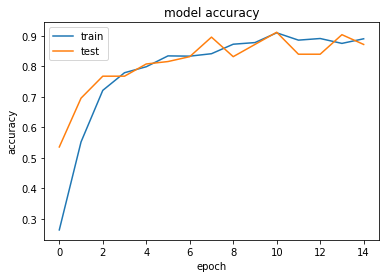

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 231)               3766917   
                                                                 
 dropout (Dropout)           (None, 231)               0         
                                                                 
 dense_1 (Dense)             (None, 303)               70296     
                                                                 
 dropout_1 (Dropout)         (None, 303)               0         
                                                                 
 dense_2 (Dense)             (None, 15)                4560      
                                                                 
Total params: 3,841,773
Trainable params: 3,841,773
Non-

In [14]:
import time

start_time = time.time()

final_nn = train_model(x_train, y_train['EMPO_3_int'], 15,
    hidden_layer_sizes=[231, 303],
    kernel_regularizer=4.5e-06,
    bias_regularizer=2.3e-05,
    activity_regularizer=5.4e-05,
    dropout=0.067,
    optimizer='Adam',
    learning_rate=0.0073,
    batch_size=64,
    num_epochs=15)

end_time = time.time()
wallclock = int(end_time - start_time)
print(f"Wallclock = {wallclock} sec")

In [15]:
final_nn_accuracy = final_nn.evaluate(x=X_val, y=Y_val['EMPO_3_int'], verbose=0, return_dict=True)['accuracy']
print(f"Accuracy of final 2-layer NN on EMPO 3: {nn2_accuracy}")

Accuracy of final 2-layer NN on EMPO 3: 0.8360000252723694


### Save fitted model

In [16]:
# Save best model as joblib or pkl file to 'model_joblibs' folder
from joblib import dump

dump(final_nn, '../model_joblibs/neural_network_EMPO3.joblib')

INFO:tensorflow:Assets written to: ram://13b83aae-efd3-40ef-8f3b-aeeff34964fa/assets


['../model_joblibs/neural_network_EMPO3.joblib']